In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from importlib import reload
from RelationalModule import MLP_AC_networks as net

from pysc2.agents import base_agent
from pysc2.lib import actions
from pysc2.lib import features
from pysc2.env import sc2_env, run_loop, available_actions_printer
from pysc2 import maps
from absl import flags

# indexes of useful layers of the screen_features
_PLAYER_RELATIVE = features.SCREEN_FEATURES.player_relative.index 
_SELECTED = features.SCREEN_FEATURES.selected.index

# Identifiers in player_relative feature layer
_BACKGROUND = 0
_PLAYER_FRIENDLY = 1
_PLAYER_ALLIES = 2
_PLAYER_NEUTRAL = 3
_PLAYER_HOSTILE = 4

# Ids of the actions that we'll use
_NO_OP = actions.FUNCTIONS.no_op.id
_MOVE_SCREEN = actions.FUNCTIONS.Attack_screen.id
_SELECT_ARMY = actions.FUNCTIONS.select_army.id

# Meaning of some arguments required by the actions
_SELECT_ALL = [0]
_NOT_QUEUED = [0]

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
race = sc2_env.Race(1) # 1 = terran
agent = sc2_env.Agent(race, "Testv0") # NamedTuple [race, agent_name]

interface_dict = dict(feature_screen=64, # screen resolution in pixel
                      feature_minimap=16, # minimap resolution in pixel (smaller or equal to screen)
                      action_space="FEATURES") # either FEATURES or RGB - suggested: FEATURES

agent_interface_format = sc2_env.parse_agent_interface_format(**interface_dict) #AgentInterfaceFormat instance

game_params = dict(map_name='MoveToBeacon', # simplest minigame
                   players=[agent], # use a list even for single player
                   agent_interface_format=[agent_interface_format] # use a list even for single player
                   )  

In [3]:
# create an envirnoment
env = sc2_env.SC2Env(**game_params, random_seed=1)

## Defining an high-level state

For sure the most relevant informations are the position of the marine and the one of the center of the beacon. Then it might be useful to have a boolean feature telling us whether the beacon exists of not in the map and finally another flag telling us if the marine is selected or not (so that instead of relying only on the final mask for the available actions we can learn that some action, e.g. select army, are more valuable if we don't have units selected).

In [4]:
def get_state(obs):
    player_relative = obs[0].observation['feature_screen'][_PLAYER_RELATIVE]
    
    player_y, player_x = (player_relative == _PLAYER_FRIENDLY).nonzero()
    player_pos = [player_x.mean(), player_y.mean()]

    beacon_ys, beacon_xs = (player_relative == _PLAYER_NEUTRAL).nonzero()
    if beacon_ys.any():
        beacon_pos = [beacon_xs.mean(), beacon_ys.mean()]
    else:
        beacon_pos = [-1., -1.]
        
    beacon_exists = float(beacon_ys.any())
    
    selected = obs[0].observation['feature_screen'][_SELECTED]
    is_selected = np.any((selected==1).nonzero()[0]).astype(float) 
    
    state = np.concatenate([player_pos, beacon_pos, [beacon_exists, is_selected]])
    
    return state

In [5]:
obs = env.reset()

In [6]:
player_relative = obs[0].observation['feature_screen'][_PLAYER_RELATIVE]
player_relative

NamedNumpyArray([[0, 0, 0, ..., 0, 0, 0],
                 [0, 0, 0, ..., 0, 0, 0],
                 [0, 0, 0, ..., 0, 0, 0],
                 ...,
                 [0, 0, 0, ..., 0, 0, 0],
                 [0, 0, 0, ..., 0, 0, 0],
                 [0, 0, 0, ..., 0, 0, 0]], [None, None], dtype=int32)

How to read:
- 0 stays for background cells
- 1 for cells owned by friendly units and buildings
- 3 for cells occupied by neutral units or objects (the beacon in our case)

Observation: interestingly enough, a map of 16 by 16 is good enough to represent both our unit and the beacon, so there is no need to consider greater resolutions.

In [7]:
selected = obs[0].observation['feature_screen'][_SELECTED]
selected

NamedNumpyArray([[0, 0, 0, ..., 0, 0, 0],
                 [0, 0, 0, ..., 0, 0, 0],
                 [0, 0, 0, ..., 0, 0, 0],
                 ...,
                 [0, 0, 0, ..., 0, 0, 0],
                 [0, 0, 0, ..., 0, 0, 0],
                 [0, 0, 0, ..., 0, 0, 0]], [None, None], dtype=int32)

In [8]:
is_selected = np.any((selected==1).nonzero()[0]).astype(float) 
is_selected

0.0

As we can see, no unit selected at the beginning...

In [9]:
action = actions.FunctionCall(_SELECT_ARMY, [_SELECT_ALL])
new_obs = env.step(actions=[action])

In [10]:
selected = new_obs[0].observation['feature_screen'][_SELECTED]
selected

NamedNumpyArray([[0, 0, 0, ..., 0, 0, 0],
                 [0, 0, 0, ..., 0, 0, 0],
                 [0, 0, 0, ..., 0, 0, 0],
                 ...,
                 [0, 0, 0, ..., 0, 0, 0],
                 [0, 0, 0, ..., 0, 0, 0],
                 [0, 0, 0, ..., 0, 0, 0]], [None, None], dtype=int32)

In [11]:
is_selected = np.any((selected==1).nonzero()[0]).astype(float) 
is_selected

1.0

## Actions

Inspecting the action specifics for this map, one can see that actually all the actions are listed, so that is not going to help in defining the action space. Moreover the available actions change w.r.t. the state, that basically is whether our unit is selected or not.

Reduce the action space to 3 moves:
1. _NO_OP
2. _SELECT_ARMY
3. _MOVE_SCREEN

Move screen is the only one that can be unavailable if the agent is not selected.

We are going to compute a custom mask starting from the available actions and the ids of these 3 actions.

In [5]:
def get_scripted_arguments(action_id, obs):
    
    if action_id == _SELECT_ARMY:
        args = [_SELECT_ALL]
        
    elif action_id == _MOVE_SCREEN:
        player_relative = obs[0].observation['feature_screen'][_PLAYER_RELATIVE]
    
        player_y, player_x = (player_relative == _PLAYER_FRIENDLY).nonzero()
        player_pos = [int(player_x.mean()), int(player_y.mean())]

        beacon_ys, beacon_xs = (player_relative == _PLAYER_NEUTRAL).nonzero()
        
        if beacon_ys.any():
            coord = [int(beacon_xs.mean()), int(beacon_ys.mean())]
        else:
            coord = player_pos
            
        args = [coord]
    
    else:
        
        args = []
        
    return args

In [13]:
reload(net)

<module 'RelationalModule.MLP_AC_networks' from '/m/home/home9/94/dainesn1/unix/Workdir/SC2-RL/RelationalModule/MLP_AC_networks.py'>

In [14]:
action_space = 3
observation_space = 6
actor = net.Actor(action_space, observation_space)

In [15]:
obs = env.reset()

state = get_state(obs)
print("state: ", state)
state = torch.tensor(state).float()

aa = obs[0].observation.available_actions

state:  [ 4.5 29.5 19.5 26.5  1.   0. ]


In [16]:
log_probs = actor(state, aa)
log_probs

tensor([-5.1424e-03, -5.2728e+00,        -inf], grad_fn=<LogSoftmaxBackward>)

In [17]:
from torch.distributions import Categorical

In [18]:
probs = torch.exp(log_probs)
distribution = Categorical(probs)
a = distribution.sample().item()
print("action: ", a)

action:  0


In [19]:
action_id = actor.action_dict[a]
print("action_id: ", action_id)

action_id:  _Functions.no_op


In [20]:
args = get_scripted_arguments(action_id, obs)
print("args: ", args)
action = actions.FunctionCall(action_id, args)

args:  [[0]]


In [21]:
obs = env.step([action])

In [22]:
state = get_state(obs)
state

array([1., 7., 5., 6., 1., 1.])

So all this part should be included in the get_action method of the actor critic.

## Defining a one-hot-encoded version of the most important layers

Given the fact that our agent was able to achieve top results from the high-level representation of the state, we now know that the layers `player_relative` and `selected` contain all the information that we need to solve the task. So the idea now is to use encode them as one-hot layers (selected layer is already binary, so doesn't need any elaboration, whereas `player_relative` has 2 values to encode, 1 and 3). This will result in a state of shape (3, map_size, map_size).

In [6]:
def get_ohe_state(obs):
    
    player_relative = obs[0].observation['feature_screen'][_PLAYER_RELATIVE]
    selected = obs[0].observation['feature_screen'][_SELECTED].astype(float)
    
    friendly = (player_relative == _PLAYER_FRIENDLY).astype(float)
    neutral = (player_relative == _PLAYER_NEUTRAL).astype(float)
    
    state = np.zeros((3,)+player_relative.shape).astype(float)
    state[0] = friendly
    state[1] = neutral
    state[2] = selected
    
    
    #print('player_relative: ',player_relative.shape)
    #print('selected: ', selected.shape)
    #print('player_relative: ',player_relative)
    #print('selected: ', selected)
    #print("state.shape: ", state.shape)
    #print("state: \n", state)
       
    return state

In [44]:
obs = env.reset()

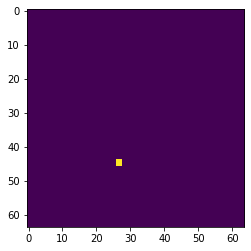

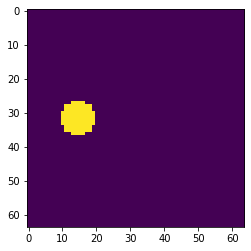

In [45]:
state = get_ohe_state(obs)
plt.imshow(state[0])
plt.show()
plt.imshow(state[1])
plt.show()

In [46]:
action = actions.FunctionCall(_SELECT_ARMY, [_SELECT_ALL])
new_obs = env.step(actions=[action])

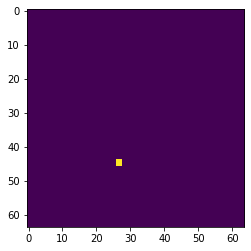

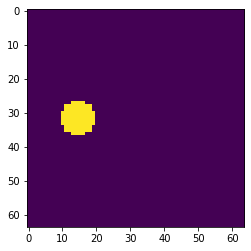

In [47]:
new_state = get_ohe_state(new_obs)
plt.imshow(new_state[0])
plt.show()
plt.imshow(new_state[1])
plt.show()

In [48]:
action = actions.FunctionCall(_MOVE_SCREEN, [_NOT_QUEUED,[4,5]])
new_obs = env.step(actions=[action])

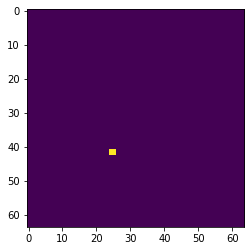

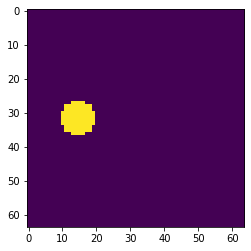

In [49]:
new_state = get_ohe_state(new_obs)
plt.imshow(new_state[0])
plt.show()
plt.imshow(new_state[1])
plt.show()

In [50]:
action = actions.FunctionCall(_MOVE_SCREEN, [_NOT_QUEUED,[4,5]])
new_obs = env.step(actions=[action])

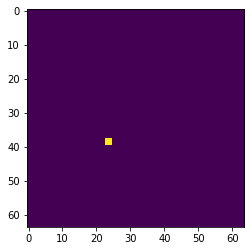

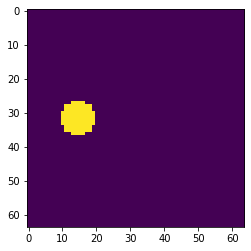

In [51]:
new_state = get_ohe_state(new_obs)
plt.imshow(new_state[0])
plt.show()
plt.imshow(new_state[1])
plt.show()

In [52]:
action = actions.FunctionCall(_MOVE_SCREEN, [_NOT_QUEUED,[4,5]])
new_obs = env.step(actions=[action])

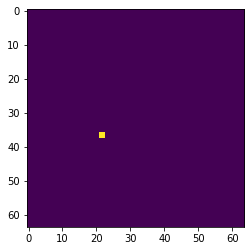

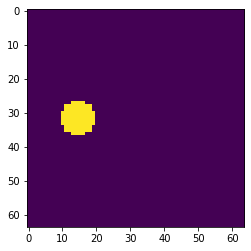

In [53]:
new_state = get_ohe_state(new_obs)
plt.imshow(new_state[0])
plt.show()
plt.imshow(new_state[1])
plt.show()

In [54]:
action = actions.FunctionCall(_NO_OP, [])
new_obs = env.step(actions=[action])

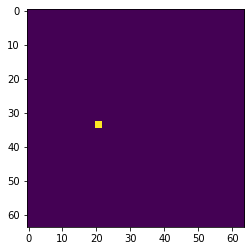

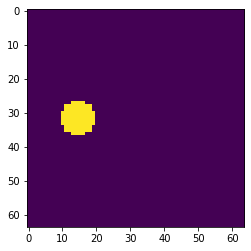

In [55]:
new_state = get_ohe_state(new_obs)
plt.imshow(new_state[0])
plt.show()
plt.imshow(new_state[1])
plt.show()

In [56]:
action = actions.FunctionCall(_NO_OP, [])
new_obs = env.step(actions=[action])

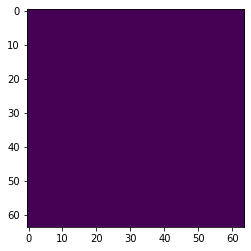

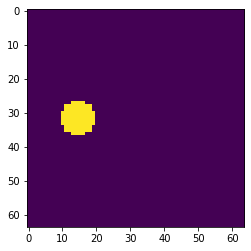

In [57]:
new_state = get_ohe_state(new_obs)
plt.imshow(new_state[0])
plt.show()
plt.imshow(new_state[1])
plt.show()

# Sampling arguments for the actions

Suppose we know which action the agent has chosen and we need to choose also the arguments.

In [4]:
# start from the simplest one
action_id = _NO_OP
# In this wayy we can see how many arguments that action accepts
print(len(actions.FUNCTIONS[action_id].args))
actions.FUNCTIONS[action_id].args

0


[]

In [5]:
len(actions.FUNCTIONS[action_id].args)

0

In [81]:
action_id = _SELECT_ARMY
print(len(actions.FUNCTIONS[action_id].args))
actions.FUNCTIONS[action_id].args

1


[ArgumentType(id=7, name='select_add', sizes=(2,), fn=<function ArgumentType.enum.<locals>.factory.<locals>.<lambda> at 0x7f619c423ef0>, values=<enum 'SelectAdd'>, count=None)]

In [83]:
action_id = _MOVE_SCREEN
print(len(actions.FUNCTIONS[action_id].args))
actions.FUNCTIONS[action_id].args[1].sizes # not used -> does not load screen resolution

2


(0, 0)

In [59]:
aa = new_obs[0].observation.available_actions # not used
len(aa)

16

In [84]:
print(len(env.action_spec()))
print(len(env.action_spec()[0]))
print(len(env.action_spec()[0][0])) # arguments ?
print(len(env.action_spec()[0][1])) # actions id ?

1
2
13
573


In [85]:
all_actions = env.action_spec()[0][1]
all_arguments = env.action_spec()[0][0]

In [86]:
print(all_actions[action_id]) # ok
print(all_actions[action_id].args)
print(all_actions[action_id].args[0])
print(all_actions[action_id].args[0].sizes)
print(all_actions[action_id].args[1])
print(all_actions[action_id].args[1].sizes)

12/Attack_screen (3/queued [2]; 0/screen [16, 16])
(ArgumentType(id=3, name='queued', sizes=(2,), fn=None, values=None, count=None), ArgumentType(id=0, name='screen', sizes=(16, 16), fn=None, values=None, count=None))
3/queued [2]
(2,)
0/screen [16, 16]
(16, 16)


In [78]:
print(all_actions[action_id].args[1].name)
print(all_actions[action_id].args[1].id)

screen
0


The more complete way to deal with sampling arguments would be to:
1. Learn a representation of the action id and concatenate it somehow to the state representation
2. For each argument type have a specific net that samples the arguments

So for example, since the action-state representation has always the same shape, all actions that require an argument of type 0 (screen) will be processed by that specific net. Basically since each argument has a completely different meaning, there is little to none transfer between certain arguments (at least in the simplest version). If two parameters are always sampled together and affect each other outcome could be more sensible to consider them as a single argument maybe (I'm thinking about drawing rectangles, in which you have to choose two points in a map and they of course influence each other...).

Keeping it as simple as possible, at the moment we have the following actions and arguments type:
1. _NO_OP (args=[ ])
2. _SELECT_ARMY (args=[ 7/select_add [2]])
3. _MOVE_SCREEN (args=[3/queued [2], 0/screen [16, 16])

So, 2 categorical arguments and a spatial one (composed by 2 numerical arguments, that in general influence one another).

Also notice that while in this exact moment every argument is unique so we wouldn't need AT ALL to concatenate also the encoded action to the input we will feed to the argument-net, in the general case the same argument can be shared by more functions, with the same meaning (of the argument, not the function), but different context. So I think it will be a good thing to start already to process and feed also the action.

In [80]:
all_arguments[0] # all is already specified in the action.args

ArgumentType(id=0, name='screen', sizes=(16, 16), fn=None, values=None, count=None)

In [88]:
for arg in all_arguments:
    print(arg)

0/screen [16, 16]
1/minimap [16, 16]
2/screen2 [16, 16]
3/queued [2]
4/control_group_act [5]
5/control_group_id [10]
6/select_point_act [4]
7/select_add [2]
8/select_unit_act [4]
9/select_unit_id [500]
10/select_worker [4]
11/build_queue_id [10]
12/unload_id [500]


As we can see, there are 3 arguments that require spatial arguments and all the other are non-spatial (probably categorical).

A simple way to discriminate between the two is to take the length of the argument: if it's 2, is spatial, otherwise is not.

In [95]:
for arg in all_arguments:
    print(arg, ' - len:', len(arg.sizes))

0/screen [16, 16]  - len: 2
1/minimap [16, 16]  - len: 2
2/screen2 [16, 16]  - len: 2
3/queued [2]  - len: 1
4/control_group_act [5]  - len: 1
5/control_group_id [10]  - len: 1
6/select_point_act [4]  - len: 1
7/select_add [2]  - len: 1
8/select_unit_act [4]  - len: 1
9/select_unit_id [500]  - len: 1
10/select_worker [4]  - len: 1
11/build_queue_id [10]  - len: 1
12/unload_id [500]  - len: 1


## Learning to sample spatial arguments

Ideally we would like to extract the x and the y NOT independently. Imagine that there are 2 points of interest: if I have to choose one of them I have 2 combinations, but if I pick x and y independently I will come up with 4 combinations, 2 of them wrong, even though the independent sampling is ideal.
So: either we sample one first and then the other, or we sample on the combinations of the two. Of course the latter has a much higher action space (e.g. 256 vs 32 for 16 by 16 map). That's why transposed convolution comes in handy: we can focus on obtaining a smaller-resolution "value map", up-sample it the best we can and take the argmax (x and y in once).

Instead if we're already conserving the spatial resolution of the input through convolution plus padding (kind of residual convolution block), we can just stack another couple of layers like that and then take the argmax (or sample in other ways, that seems a better option for spatial arguments in particular).

In [7]:
import torch.nn.functional as F
from torch.distributions import Categorical

In [16]:
size = 2
# let's say this are the logits in output, each corresponding to a spatial argument value
x = torch.tensor([[-10,1],[-10,-10]]).float().unsqueeze(0)
print(x.shape)
x = x.reshape(x.shape[:-2]+(-1,))
print(x.shape)
log_probs = F.log_softmax(x, dim=(-1))
print(log_probs)
probs = torch.exp(log_probs)
print(probs)
print(probs.sum())

torch.Size([1, 2, 2])
torch.Size([1, 4])
tensor([[-1.1000e+01, -5.0067e-05, -1.1000e+01, -1.1000e+01]])
tensor([[1.6701e-05, 9.9995e-01, 1.6701e-05, 1.6701e-05]])
tensor(1.)


In [20]:
x_lin = torch.arange(size)
xx = x_lin.repeat(size,1)
args = torch.cat([xx.view(size,size,1), xx.T.view(size,size,1)], axis=2)
print(args)
args = args.reshape(-1,2)
print(args.shape)
print(args)

tensor([[[0, 0],
         [1, 0]],

        [[0, 1],
         [1, 1]]])
torch.Size([4, 2])
tensor([[0, 0],
        [1, 0],
        [0, 1],
        [1, 1]])


In [18]:
distribution = Categorical(probs)
index = distribution.sample().item() # detaching it, is it okay? maybe...
args[index] # and this are the sampled coordinates in x and y, not y and x!

tensor([1, 0])

## Complication: actor update

Without composite actions we had the following loss for each action:
$L = -A(s) \cdot log(\pi(a|s))$ <br>
Now we decompose the action and the policy like this: <br>
$a = (a^0,a^1,\ldots,a^n)$, <br>
where $a^0$ is the action identifier and all the others are the arguments; <br>
$\pi(a|s) = \left(\prod_{i=1}^{n}\pi_i(a^i|a^0,s)\right) \cdot \pi_0(a^0|s)$, <br>
assuming that all the $a^i, i=1,\ldots,n$ are sampled independently from each other but conditioned to the sampled $a^0$. 

Plugging all together inside the previous formula: <br>
$L = -A(s) \cdot \left(\sum_{i=1}^{n}log(\pi_i(a^i|a^0,s)) + log(\pi_0(a^0|s)))\right)$

If then for semplicity / for the moment we drop also the $a^0$ dependence: <br>
$L = -A(s) \cdot \sum_{i=0}^{n}log(\pi_i(a^i|s))$

Forgetting about the full entropy regularization (because it becomes more complicated than it's worth), we can simply return the sum of all the logarithms, the one of the action and those of its parameters, and make the AC update as usual.

# Architectures

The architectures for choosing the action's argument will depend on how the state representation is, array-like or matrix-like.

<img src="Supplementary material/SC2 architectures.png">

Let's start considering an array-like representation (that is the one we are using in agent 2 successfully):

In [136]:
n_features = 24
state_rep = torch.rand(1,n_features)

In [133]:
import torch.nn as nn

In [183]:
class CategoricalNet(nn.Module):
    
    def __init__(self, n_features, size, hiddens=[32,16]):
        super(CategoricalNet, self).__init__()
        layers = []
        
        layers.append(nn.Linear(n_features, hiddens[0]))
        layers.append(nn.ReLU())
            
        for i in range(0,len(hiddens)-1):
            layers.append(nn.Linear(hiddens[i], hiddens[i+1]))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hiddens[-1], size))
        self.net = nn.Sequential(*layers)
        
    def forward(self, state_rep):
        logits = self.net(state_rep)
        log_probs = F.log_softmax(logits, dim=(-1))
        probs = torch.exp(log_probs)
        distribution = Categorical(probs)
        arg = distribution.sample().item() 
        return arg, log_probs.view(-1)[arg], probs

In [213]:
categorical_net = CategoricalNet(24, 2)
arg, log_prob, probs = categorical_net(state_rep)
print("arg: ", arg)
print("log_prob: ", log_prob)
print("probs.shape; ", probs.shape)
print("probs.sum(); ", probs.sum())

arg:  1
log_prob:  tensor(-0.6344, grad_fn=<SelectBackward>)
probs.shape;  torch.Size([1, 2])
probs.sum();  tensor(1., grad_fn=<SumBackward0>)


In [218]:
debug = True

class SpatialNet(nn.Module):
    
    def __init__(self, n_features, size=[16,16], n_channels=12):
        super(SpatialNet, self).__init__()
        
        self.size = size[0]
        
        self.linear = nn.Linear(n_features, (size[0]-6)*(size[1]-6))
        
        self.conv_block = nn.Sequential(
                                        nn.ConvTranspose2d(in_channels=1, 
                                                           out_channels=n_channels, 
                                                            kernel_size=3),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(in_channels=n_channels, 
                                                           out_channels=n_channels, 
                                                           kernel_size=3),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(in_channels=n_channels, 
                                                              out_channels=n_channels, 
                                                              kernel_size=3)
                                        )
        
    def forward(self, state_rep):
        if debug: print("state_rep.shape: ", state_rep.shape)
            
        x = F.relu(self.linear(state_rep))
        if debug: print("x.shape (after linear): ", x.shape)
            
        x = x.reshape(x.shape[0], 1, size[0]-6, size[1]-6)
        if debug: print("x.shape (after reshape): ", x.shape)
            
        x = self.conv_block(x)
        if debug: print("x.shape (after conv block): ", x.shape)
            
        x, _ = torch.max(x, axis=1)
        if debug: print("x.shape (after maxpool): ", x.shape)
            
        x = x.reshape(x.shape[:-2]+(-1,))
        
        log_probs = F.log_softmax(x, dim=(-1))
        if debug: 
            print("log_probs.shape: ", log_probs.shape)
            print("log_probs.shape (reshaped): ", log_probs.view(self.size, self.size).shape)
        probs = torch.exp(log_probs)
        
        # assume squared space
        x_lin = torch.arange(self.size)
        xx = x_lin.repeat(self.size,1)
        args = torch.cat([xx.view(self.size,self.size,1), xx.T.view(self.size,self.size,1)], axis=2)
        args = args.reshape(-1,2)
        
        distribution = Categorical(probs)
        index = distribution.sample().item() # detaching it, is it okay? maybe...
        arg = args[index] # and this are the sampled coordinates
        arg = arg.detach().numpy()
        return arg, log_probs.view(self.size, self.size)[arg[0], arg[1]], probs

**Spatial net architecture:**

1. **Linear layer + relu:** <br>
    (b, n_features) -> (b, (size[0]-6)^2)
2. **Reshape for convolution:** <br>
    (b, (size[0]-6)^2) -> (b, 1, size[0]-6, size[1]-6)
3. **Transpose Convolution 2D + relu:** <br>
    (b, 1, size[0]-6, size[1]-6) -> (b, n_channels, size[0]-4, size[1]-4)
3. **Transpose Convolution 2D + relu:** <br>
    (b, n_channels, size[0]-4, size[1]-4) -> (b, n_channels, size[0]-2, size[1]-2)
4. **Transpose Convolution 2D :** <br>
    (b, n_channels, size[0]-2, size[1]-2) -> (b, n_channels, size[0], size[1])
5. **Pixel-wise max pooling:** <br>
    (b, n_channels, size[0], size[1]) -> (b, size[0], size[1])

In [219]:
screen_net = SpatialNet(24)
arg, log_prob, probs = screen_net(state_rep)
print("arg: ", arg)
print("log_prob: ", log_prob)
print("probs.shape; ", probs.shape)
print("probs.sum(); ", probs.sum())

state_rep.shape:  torch.Size([1, 24])
x.shape (after linear):  torch.Size([1, 100])
x.shape (after reshape):  torch.Size([1, 1, 10, 10])
x.shape (after conv block):  torch.Size([1, 12, 16, 16])
x.shape (after maxpool):  torch.Size([1, 16, 16])
log_probs.shape:  torch.Size([1, 256])
log_probs.shape (reshaped):  torch.Size([16, 16])
arg:  [ 8 12]
log_prob:  tensor(-5.5477, grad_fn=<SelectBackward>)
probs.shape;  torch.Size([1, 256])
probs.sum();  tensor(1., grad_fn=<SumBackward0>)


# Automatic instantiation of the argument nets

In [194]:
# Info that we need to know beforehand
action_dict = {0:_NO_OP, 1:_SELECT_ARMY, 2:_MOVE_SCREEN}
all_actions = env.action_spec()[0][1]
all_arguments = env.action_spec()[0][0]
n_features = 24

In [203]:
debug = True
arguments_networks = {}
arguments_dict = {}

for a in action_dict:
    action = all_actions[action_dict[a]]
    args = action.args
    
    for arg in args:
        arguments_dict[arg.name] = arg.id # store 'name':id pairs for future use
        print('\narg.name: ', arg.name)
        
        size = all_arguments[arg.id].sizes
        if debug: print('size: ', size)
        if len(size) == 1:
            print("Init CategoricalNet for "+arg.name+' argument')
            arguments_networks[arg.name] = CategoricalNet(n_features, size[0]) # hiddens as 3rd arg if needed
        else:
            print("Init SpatialNet for "+arg.name+' argument')
            arguments_networks[arg.name] = SpatialNet(n_features, size) # in_channels as 3rd arg if needed


arg.name:  select_add
size:  (2,)
Init CategoricalNet for select_add argument

arg.name:  queued
size:  (2,)
Init CategoricalNet for queued argument

arg.name:  screen
size:  (16, 16)
Init SpatialNet for screen argument


In [209]:
arguments_dict

{'select_add': 7, 'queued': 3, 'screen': 0}

In [226]:
l = [torch.rand(1), torch.rand(1)]
print(l)
torch.stack(l).sum()

[tensor([0.6066]), tensor([0.6278])]


tensor(1.2344)